# Rational Expectations Agricultural Market Model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demintro02.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2026-Jan-04</i>
<hr>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from compecon import qnwlogn, discmoments
plt.style.use('seaborn-v0_8-dark')
plt.style.use('seaborn-v0_8-talk')
pd.set_option('display.precision', 4)

Generate yield distribution

In [2]:
sigma2 = 0.2 ** 2
y, w = qnwlogn(25, -0.5 * sigma2, sigma2)

Compute rational expectations equilibrium using function iteration, iterating on acreage planted

In [3]:
def A(aa, pp):
    """
    Parameters
        aa: acreage
        pp: target price
    """
    return 0.5 + 0.5 * np.dot(w, np.maximum(1.5 - 0.5 * aa * y, pp))

ptarg = 1.0 # target price
a = 1.0     # initial guess for acreage

print(f"{'it':^4s} {'a':^8s} {'|a-aold|':^8s}", '='*22, sep='\n')
for it in range(50):
    aold = a
    a = A(a, ptarg)
    print(f'{it:4d} {a:8.4f} {abs(a-aold):8.1e}')
    if abs(a - aold) < 1.e-8:
        break

 it     a     |a-aold|
   0   1.0198  2.0e-02
   1   1.0171  2.7e-03
   2   1.0175  3.7e-04
   3   1.0174  5.0e-05
   4   1.0174  6.8e-06
   5   1.0174  9.3e-07
   6   1.0174  1.3e-07
   7   1.0174  1.7e-08
   8   1.0174  2.3e-09


Intermediate outputs

In [4]:
q = a * y                # quantity produced in each state
p = 1.5 - 0.5 * a * y    # market price in each state
f = np.maximum(p, ptarg) # farm price in each state
r = f * q                # farm revenue in each state
g = (f - p) * q          #government expenditures

varnames = ['Market Price', 'Farm Price', 'Farm Revenue', 'Government Expenditures']

data = pd.DataFrame(index=varnames, columns=['Expect', 'Std Dev'])
data['Expect'], data['Std Dev'] = discmoments(w, np.vstack((p, f, r, g)))
data


,Expect,Std Dev
Market Price,0.9913,0.1028
Farm Price,1.0348,0.0506
Farm Revenue,1.0447,0.1773
Government Expenditures,0.0573,0.1038


Generate fixed-point mapping

In [5]:
aeq = a
a = np.linspace(0, 2, 100)
g = np.array([A(k, ptarg) for k in a])

### Graph rational expectations equilibrium

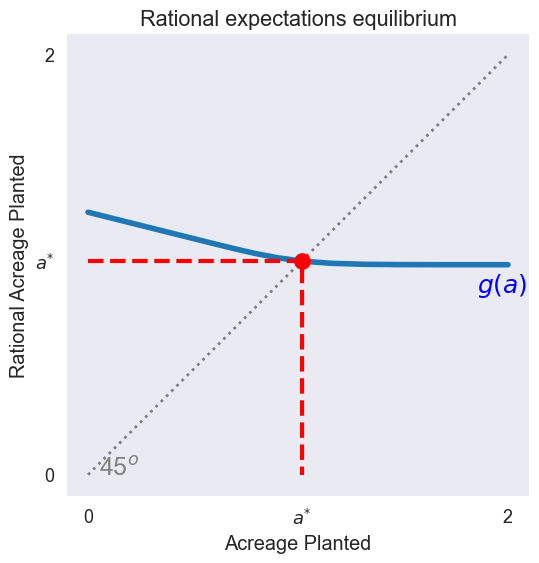

In [6]:
fig1, ax = plt.subplots(figsize=[6, 6])
ax.plot(a, g, linewidth=4)
ax.plot(a, a, ':', color='grey', linewidth=2)
ax.plot([0, aeq, aeq], [aeq, aeq, 0], 'r--', linewidth=3)
ax.plot([aeq], [aeq], 'ro', markersize=12)

ax.text(0.05, 0, '45${}^o$', color='grey')
ax.text(1.85, aeq - 0.15,'$g(a)$', color='blue')

ax.set(title='Rational expectations equilibrium', 
       aspect=1,
       xlabel='Acreage Planted', 
       xticks=[0, aeq, 2], 
       xticklabels=['0', '$a^{*}$', '2'],
       ylabel='Rational Acreage Planted', 
       yticks=[0, aeq, 2],
       yticklabels=['0', '$a^{*}$', '2']);

### Compute rational expectations equilibrium as a function of the target price

In [7]:
def solve_farm_problem(ptarg):
    a=1.0 # initial guess

    for it in range(50):
        aold = a
        a = A(a, ptarg)
        if abs(a - aold) < 1.e-10:
            break

    q = a * y                       # quantity produced
    p = 1.5 - 0.5 * a * y           # market price
    f = np.maximum(p, ptarg)    # farm price
    r = f * q                       # farm revenue
    g = (f - p) * q                 # government expenditures

    return discmoments(w, np.vstack((p, f, r, g)))


nplot = 50
ptargets = np.linspace(0, 2, nplot)

E = pd.DataFrame(index=ptargets, columns=varnames)
S = pd.DataFrame(index=ptargets, columns=varnames)
E.index.name = 'Target price'
S.index.name = 'Target price'


for ptarg in ptargets:
    E.loc[ptarg], S.loc[ptarg] = solve_farm_problem(ptarg)


### Graph expected prices vs target price

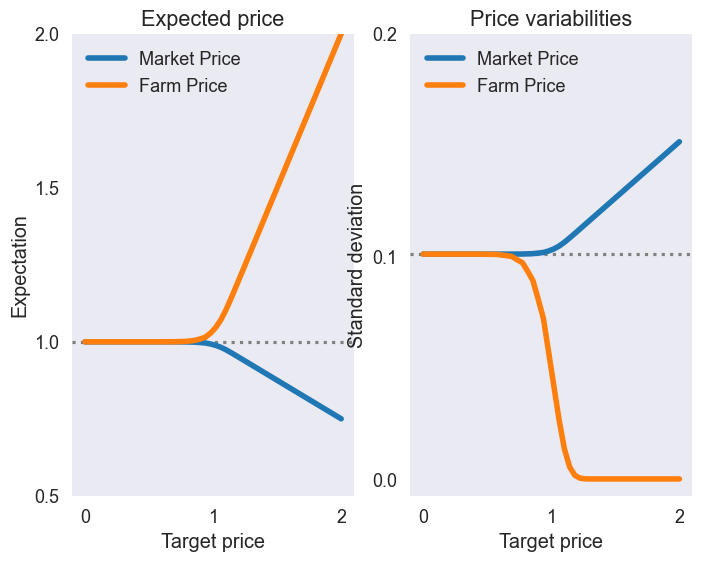

In [8]:
zeroline = lambda y, ax: ax.axhline(y.iloc[0], linestyle=':', color='gray')

fig2, (ax1,ax2) = plt.subplots(1, 2, figsize=[8, 6])

zeroline(E['Market Price'], ax1)
E[['Market Price','Farm Price']].plot(ax=ax1, linewidth=4)
ax1.set(title='Expected price',
        xticks=[0, 1, 2],
        ylabel='Expectation', 
        yticks=[0.5, 1, 1.5, 2], 
        ylim=[0.5, 2.0])

ax1.legend(loc='upper left')

# Graph expected prices vs target price
zeroline(S['Farm Price'], ax2)
S[['Market Price','Farm Price']].plot(ax=ax2, linewidth=4)
ax2.set(title='Price variabilities',
        xticks=[0, 1, 2],
        ylabel='Standard deviation', 
        yticks=[0, 0.1, 0.2]) 

ax2.legend(loc='upper left');

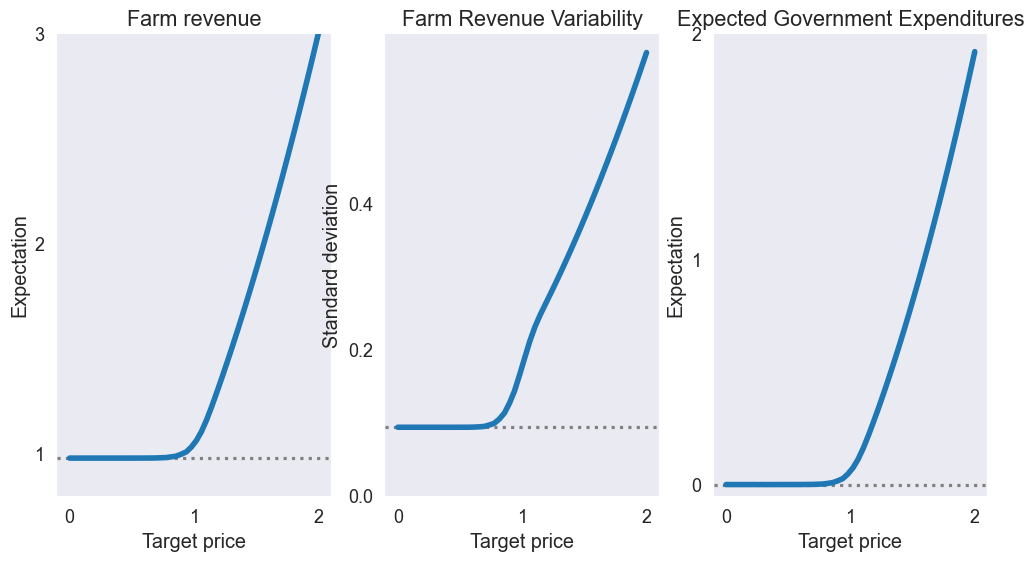

In [9]:
fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[12, 6])

# Graph expected farm revenue vs target price
zeroline(E['Farm Revenue'], ax1)
E['Farm Revenue'].plot(ax=ax1, linewidth=4)
ax1.set(title='Farm revenue',
        xticks=[0, 1, 2],
        ylabel='Expectation', 
        yticks=[1, 2, 3], 
        ylim=[0.8, 3.0])

# Graph standard deviation of farm revenue vs target price
zeroline(S['Farm Revenue'], ax2)
S['Farm Revenue'].plot(ax=ax2, linewidth=4)
ax2.set(title='Farm Revenue Variability',
        xticks=[0, 1, 2],
        ylabel='Standard deviation', 
        yticks=[0, 0.2, 0.4])

# Graph expected government expenditures vs target price
zeroline(E['Government Expenditures'], ax3)
E['Government Expenditures'].plot(ax=ax3, linewidth=4)
ax3.set(title='Expected Government Expenditures',
        xticks=[0, 1, 2],
        ylabel='Expectation', 
        yticks=[0, 1, 2], 
        ylim=[-0.05, 2.0]);

Text(0, 0.5, 'Standard deviation')

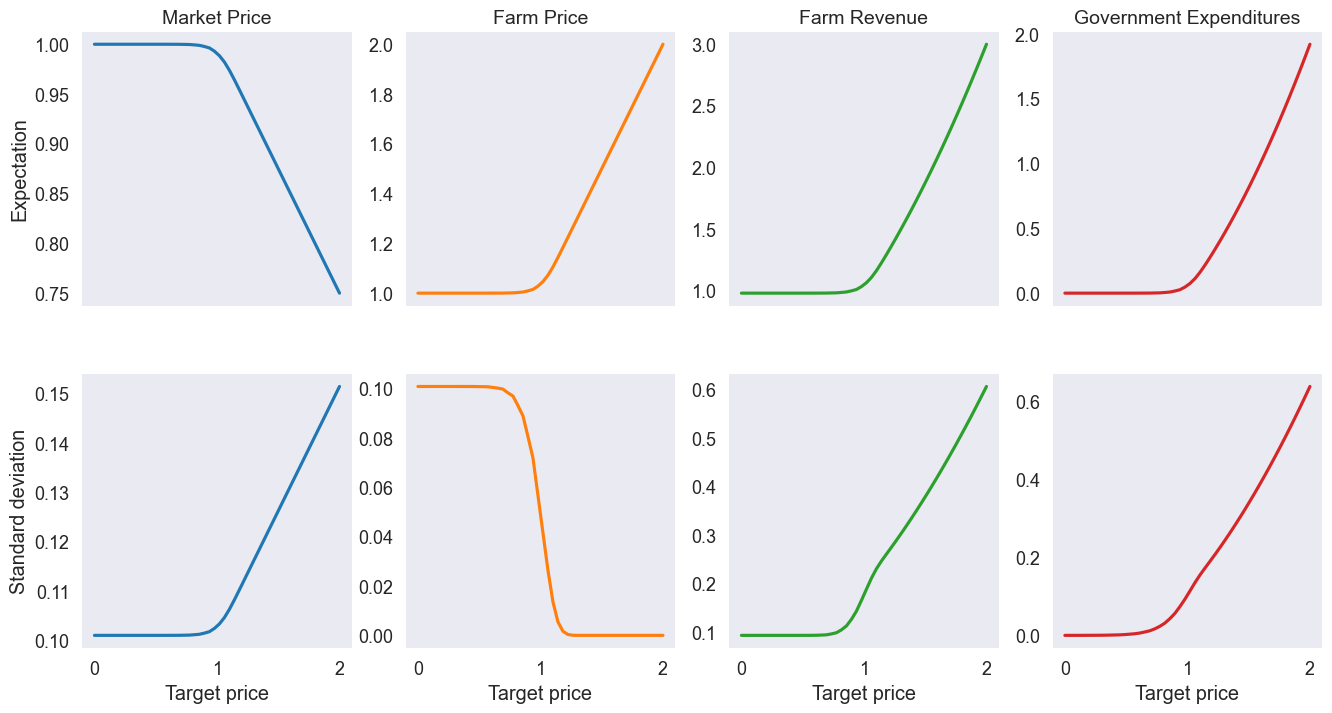

In [10]:
fig4, axs = plt.subplots(2, 4, figsize=[16,8], sharex=True)
E.plot(subplots=True, ax=axs[0], legend=None);
S.plot(subplots=True, ax=axs[1], legend=None);

for ax, tlt in zip(axs[0], E):
    ax.set_title(tlt, size=14)

axs[0,0].set_ylabel('Expectation')    
axs[1,0].set_ylabel('Standard deviation')    